# Composing Models

Now that we have learned how to specify composition patterns and primitive models, we can learn how to combine them into a composite model.

In [1]:
using SyntacticModels

using SyntacticModels.AMR
using SyntacticModels.ASKEMDecapodes
using SyntacticModels.ASKEMUWDs
using SyntacticModels.Composites

using MLStyle
import SyntacticModels.ASKEMDecapodes.Decapodes as Decapodes
using Catlab
using Catlab.RelationalPrograms
using Catlab.WiringDiagrams
using Test
using JSON3

draw(uwd) = to_graphviz(uwd, box_labels=:name, junction_labels=:variable)

draw (generic function with 1 method)

## Specifying the Composition Pattern

We can build an Undirected Wiring Diagram to represent the pattern of composition.
In this model we have 3 variables X,V,Q, which are all the same type.

In [2]:
x = Typed(:X, :Form0)
v = Typed(:V, :Form0)
Q = Typed(:Q, :Form0)
variables = [x,v,Q]

3-element Vector{SyntacticModels.ASKEMUWDs.Typed}:
 SyntacticModels.ASKEMUWDs.Typed(:X, :Form0)
 SyntacticModels.ASKEMUWDs.Typed(:V, :Form0)
 SyntacticModels.ASKEMUWDs.Typed(:Q, :Form0)

Our system will expose two variables namely x and Q to the outside world.
These variables could be used as a basis for further composition, or measured by an observer.
The system also hase two subsystems an oscillator that couples `X` and `V` and
a heating element that couples `V` and `Q`.

In [3]:
c = [x, Q]
s = [Statement(:oscillator, [x,v]),
  Statement(:heating, [v,Q])]
u = ASKEMUWDs.UWDExpr(c, s)

SyntacticModels.ASKEMUWDs.UWDExpr(SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Typed(:X, :Form0), SyntacticModels.ASKEMUWDs.Typed(:Q, :Form0)], SyntacticModels.ASKEMUWDs.Statement[SyntacticModels.ASKEMUWDs.Statement(:oscillator, SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Typed(:X, :Form0), SyntacticModels.ASKEMUWDs.Typed(:V, :Form0)]), SyntacticModels.ASKEMUWDs.Statement(:heating, SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Typed(:V, :Form0), SyntacticModels.ASKEMUWDs.Typed(:Q, :Form0)])])

This `UWDExpr` can be interpreted with Catlab as a set of tables.

In [4]:
u_tables = ASKEMUWDs.construct(RelationDiagram, u)

Catlab.Programs.RelationalPrograms.TypedUnnamedRelationDiagram{Symbol, Symbol, Symbol} {Box:2, Port:4, OuterPort:2, Junction:3, Type:0, Name:0, VarName:0}
┌─────┬────────────┐
│ Box │       name │
├─────┼────────────┤
│   1 │ oscillator │
│   2 │    heating │
└─────┴────────────┘
┌──────┬─────┬──────────┬───────────┐
│ Port │ box │ junction │ port_type │
├──────┼─────┼──────────┼───────────┤
│    1 │   1 │        1 │     Form0 │
│    2 │   1 │        3 │     Form0 │
│    3 │   2 │        3 │     Form0 │
│    4 │   2 │        2 │     Form0 │
└──────┴─────┴──────────┴───────────┘
┌───────────┬────────────────┬─────────────────┐
│ OuterPort │ outer_junction │ outer_port_type │
├───────────┼────────────────┼─────────────────┤
│         1 │              1 │               X │
│         2 │              2 │               Q │
└───────────┴────────────────┴─────────────────┘
┌──────────┬───────────────┬──────────┐
│ Junction │ junction_type │ variable │
├──────────┼───────────────┼──────────┤
│        1 │         Form0 │        X │
│        2 │         Form0 │        Q │
│        3 │         Form0 │        V │
└──────────┴───────────────┴──────────┘

And visualized with graphviz as a UWD drawing.

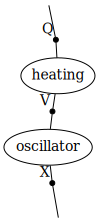

In [5]:
draw(u_tables)

## Specifying the Component Systems

A key component of using these serialized syntactic representations is that they need to be self-describing in files.
This is where the Header blocks come in.

In [6]:
h = AMR.Header("harmonic_oscillator",
  "modelreps.io/DecaExpr",
  "A Simple Harmonic Oscillator as a Diagrammatic Equation",
  "DecaExpr",
  "v1.0")

SyntacticModels.AMR.Header("harmonic_oscillator", "modelreps.io/DecaExpr", "A Simple Harmonic Oscillator as a Diagrammatic Equation", "DecaExpr", "v1.0")

The easiest way to write down a DecaExpr is in our DSL and calling the parser.

In [7]:
dexpr = Decapodes.parse_decapode(quote
  X::Form0{Point}
  V::Form0{Point}

  k::Constant{Point}

  ∂ₜ(X) == V
  ∂ₜ(V) == -1*k*(X)
end
)

Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:X), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:V), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:k), :Constant, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:X)), Decapodes.Var(:V)), Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:V)), Decapodes.Mult(Decapodes.Term[Decapodes.Lit(Symbol("-1")), Decapodes.Var(:k), Decapodes.Var(:X)]))])

That gave us the first model

In [8]:
d1 = ASKEMDecaExpr(h, dexpr)

SyntacticModels.ASKEMDecapodes.ASKEMDecaExpr(SyntacticModels.AMR.Header("harmonic_oscillator", "modelreps.io/DecaExpr", "A Simple Harmonic Oscillator as a Diagrammatic Equation", "DecaExpr", "v1.0"), Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:X), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:V), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:k), :Constant, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:X)), Decapodes.Var(:V)), Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:V)), Decapodes.Mult(Decapodes.Term[Decapodes.Lit(Symbol("-1")), Decapodes.Var(:k), Decapodes.Var(:X)]))]))

The second model is:

In [9]:
d2 = ASKEMDecaExpr(
  AMR.Header("fricative_heating",
   "modelreps.io/SummationDecapode",
   "Velocity makes it get hot, but you dissipate heat away from Q₀",
   "SummationDecapode", "v1.0"),
    Decapodes.parse_decapode(quote
      V::Form0{Point}
      Q::Form0{Point}
      κ::Constant{Point}
      λ::Constant{Point}
      Q₀::Parameter{Point}

      ∂ₜ(Q) == κ*V + λ(Q - Q₀)
    end)
)

SyntacticModels.ASKEMDecapodes.ASKEMDecaExpr(SyntacticModels.AMR.Header("fricative_heating", "modelreps.io/SummationDecapode", "Velocity makes it get hot, but you dissipate heat away from Q₀", "SummationDecapode", "v1.0"), Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:V), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:Q), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:κ), :Constant, :Point), Decapodes.Judgement(Decapodes.Var(:λ), :Constant, :Point), Decapodes.Judgement(Decapodes.Var(:Q₀), :Parameter, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Tan(Decapodes.Var(:Q)), Decapodes.Plus(Decapodes.Term[Decapodes.App2(:*, Decapodes.Var(:κ), Decapodes.Var(:V)), Decapodes.App1(:λ, Decapodes.App2(:-, Decapodes.Var(:Q), Decapodes.Var(:Q₀)))]))]))

Now we can assemble this bad boi:

In [10]:
h = AMR.Header("composite_physics", "modelreps.io/Composite", "A composite model", "CompositeModelExpr", "v0.0")
m = CompositeModelExpr(h, u, [OpenModel(d1, [:X, :V]), OpenModel(d2, [:V, :Q])])
@test interface(m) == [:X, :Q]

Test Passed

The `CompositeModelExpr` is a tree that stores the composition pattern and the models that are to be composed.
You can see from this little model (just two coupled odes) that the json output will not be human writeable.
This is why we need a library for Syntactic Model representations.

In [11]:
JSON3.pretty(m, JSON3.AlignmentContext(indent=2))

{
  "components": [
    {
      "interface": [
        "X",
        "V"
      ],
      "_type": "OpenModel",
      "model": {
        "header": {
          "description": "A Simple Harmonic Oscillator as a Diagrammatic Equation",
          "name": "harmonic_oscillator",
          "_type": "Header",
          "model_version": "v1.0",
          "schema": "modelreps.io/DecaExpr",
          "schema_name": "DecaExpr"
        },
        "_type": "ASKEMDecaExpr",
        "model": {
          "context": [
            {
              "dim": "Form0",
              "var": {
                "name": "X",
                "_type": "Var"
              },
              "space": "Point",
              "_type": "Judgement"
            },
            {
              "dim": "Form0",
              "var": {
                "name": "V",
                "_type": "Var"
              },
              "space": "Point",
              "_type": "Judgement"
            },
            {
              "dim": "Constant"

We can interpret this big data structure to execute a composition!
Notice how the variables in the composite model are namespaced with the subsystem they came from.
The coupled variables get their names from the UWD and thus live in the top level namespace.

Var,type,name
1,Form0,X
2,Form0,V
3,Constant,oscillator_k
4,infer,oscillator_mult_1
5,infer,oscillator_V̇
6,Literal,-1
7,Form0,Q
8,Constant,heating_κ
9,Constant,heating_λ
10,Parameter,heating_Q₀


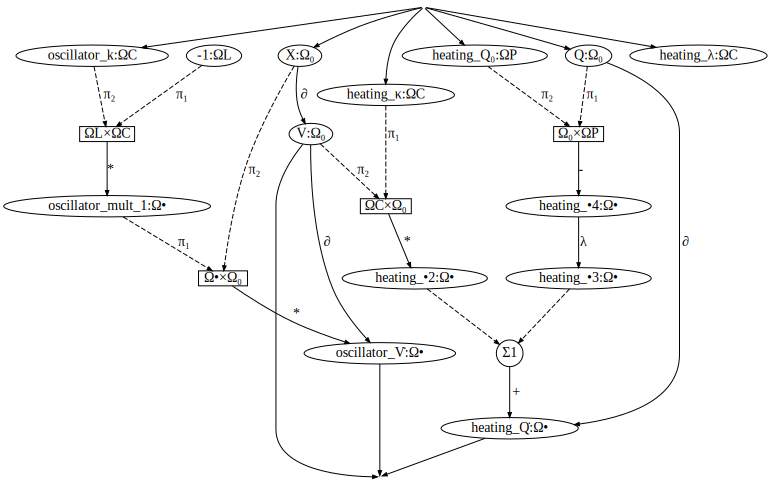

In [12]:
composite = oapply(m)
display(apex(composite))
to_graphviz(apex(composite))

*Important: because the oapply algorithm operates on the compute graph representation of the equations, it does not produce syntactic equations. Calls to `oapply` produce instances of `OpenDecapode` and not `DecaExpr`. Software that expects to consume decapodes should plan to interact with both forms.*

## Nested Composition
In this section we will build a model that is a composite of composites of models.
This demonstrates that the Decapodes system can recursively compose multiphysics models.

In [13]:
Q₊ = Untyped(:Q₊)
Q₋ = Untyped(:Q₋)
Q̇ = Untyped(:Q̇)
uwdʰ = UWDExpr([v, Q], [Statement(:drag, [v, Q₊]), Statement(:cooling, [Q₋, Q]), Statement(:superposition, [Q₊, Q₋, Q̇])])

SyntacticModels.ASKEMUWDs.UWDExpr(SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Typed(:V, :Form0), SyntacticModels.ASKEMUWDs.Typed(:Q, :Form0)], SyntacticModels.ASKEMUWDs.Statement[SyntacticModels.ASKEMUWDs.Statement(:drag, SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Typed(:V, :Form0), SyntacticModels.ASKEMUWDs.Untyped(:Q₊)]), SyntacticModels.ASKEMUWDs.Statement(:cooling, SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Untyped(:Q₋), SyntacticModels.ASKEMUWDs.Typed(:Q, :Form0)]), SyntacticModels.ASKEMUWDs.Statement(:superposition, SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Untyped(:Q₊), SyntacticModels.ASKEMUWDs.Untyped(:Q₋), SyntacticModels.ASKEMUWDs.Untyped(:Q̇)])])

Our new model has 3 subsystems, drag, cooling, and superposition. A key innovation of decapodes is to realize that
even simple systems like drag are actually multiphysical, they have some term that represents a force,
and some term that determines how that force changes the state of the system. In order to write models compositionally,
you must first break them down into their atomic subsystems, which are smaller than you think.

Our three primitive subsystems are each composed of one equation. Of course at this scale of complexity, you don't
need to do compositional specification, you can just compose them in your head and write down the composite.
But this is a tutorial, so we are building a very simple model as a composite of atomic models (one equation each).

In [14]:
drag = ASKEMDecaExpr(
  AMR.Header("DragHeat", "modelreps.io/SummationDecapode", "velocity makes it get hot", "SummationDecapode", "v1.0"),
  Decapodes.parse_decapode(quote
    V::Form0{Point}
    Q₊::Form0{Point}
    κ::Constant{Point}

    Q₊ == κ*V
  end)
)

cooling = ASKEMDecaExpr(
  AMR.Header("NetwonCooling", "modelreps.io/SummationDecapode", "heat dissipates to the enviornment", "SummationDecapode", "v1.0"),
  Decapodes.parse_decapode(quote
    Q₋::Form0{Point}
    Q₀::Parameter{Point}
    Q::Form0{Point}
    λ::Constant{Point}

    Q₋ == λ(Q-Q₀)
  end)
)

superposition = ASKEMDecaExpr(
  AMR.Header("LinearSuperpositon", "modelreps.io/SummationDecapode", "variables be addin", "SummationDecapode", "v1.0"),
  Decapodes.parse_decapode(quote
    X::Form0{Point}
    Y::Form0{Point}
    T::Form0{Point}

    T == X + Y
  end)
)

SyntacticModels.ASKEMDecapodes.ASKEMDecaExpr(SyntacticModels.AMR.Header("LinearSuperpositon", "modelreps.io/SummationDecapode", "variables be addin", "SummationDecapode", "v1.0"), Decapodes.DecaExpr(Decapodes.Judgement[Decapodes.Judgement(Decapodes.Var(:X), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:Y), :Form0, :Point), Decapodes.Judgement(Decapodes.Var(:T), :Form0, :Point)], Decapodes.Equation[Decapodes.Eq(Decapodes.Var(:T), Decapodes.Plus(Decapodes.Term[Decapodes.Var(:X), Decapodes.Var(:Y)]))]))

The `CompositeModelExpr` type can store recursive model descriptions in terms of compositions of composite models.

In [15]:
h = AMR.Header("hierarchical_composite", "modelreps.io/Composite", "A hierarchical composite model of frictional heating", "CompositeModelExpr", "v0.1")
m = CompositeModelExpr(h,u, [OpenModel(d1, [:X, :V]),
      CompositeModelExpr(AMR.Header("heating_dynamics", "modelreps.io/Composite", "A formula for heating - cooling", "CompositeModelExpr", "v0.1"),
        uwdʰ, [OpenModel(drag, [:V, :Q₊]), OpenModel(cooling, [:Q₋, :Q]), OpenModel(superposition, [:X, :Y, :T])])
])

SyntacticModels.Composites.CompositeModelExpr(SyntacticModels.AMR.Header("hierarchical_composite", "modelreps.io/Composite", "A hierarchical composite model of frictional heating", "CompositeModelExpr", "v0.1"), SyntacticModels.ASKEMUWDs.UWDExpr(SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Typed(:X, :Form0), SyntacticModels.ASKEMUWDs.Typed(:Q, :Form0)], SyntacticModels.ASKEMUWDs.Statement[SyntacticModels.ASKEMUWDs.Statement(:oscillator, SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Typed(:X, :Form0), SyntacticModels.ASKEMUWDs.Typed(:V, :Form0)]), SyntacticModels.ASKEMUWDs.Statement(:heating, SyntacticModels.ASKEMUWDs.Var[SyntacticModels.ASKEMUWDs.Typed(:V, :Form0), SyntacticModels.ASKEMUWDs.Typed(:Q, :Form0)])]), SyntacticModels.Composites.CompositeModel[SyntacticModels.Composites.OpenModel(SyntacticModels.ASKEMDecapodes.ASKEMDecaExpr(SyntacticModels.AMR.Header("harmonic_oscillator", "modelreps.io/DecaExpr", "A Simple Harmonic Oscillator as a Diagrammatic Equation"

The `oapply` function will recursively descend the tree to assemble a flat model with hierarchical namespacing.

In [16]:
dh = apex(oapply(m))

Var,type,name
1,Form0,X
2,Form0,V
3,Constant,oscillator_k
4,infer,oscillator_mult_1
5,infer,oscillator_V̇
6,Literal,-1
7,Form0,heating_Q₊
8,Constant,heating_drag_κ
9,Form0,heating_Q₋
10,Parameter,heating_cooling_Q₀


This model can also be drawn as a decapode.

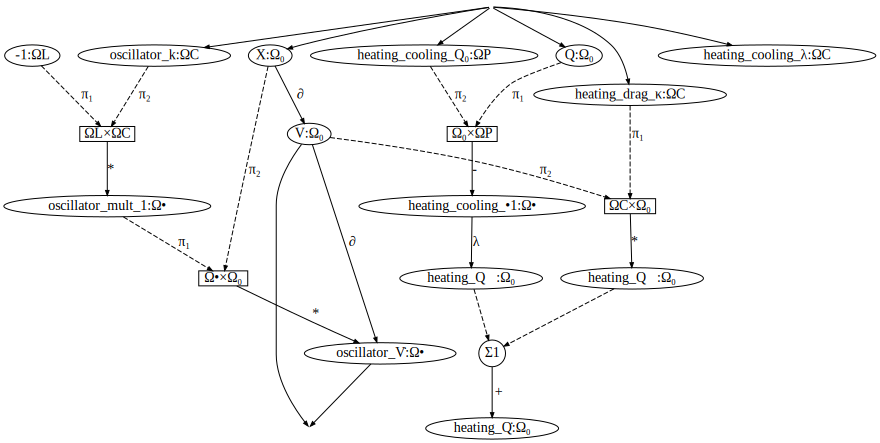

In [17]:
to_graphviz(dh)

The new model description needs to be written by hand for the new model header. Some annotation in the description can't be avoided, yet.

In [18]:
composite = OpenDecapode(m)
hf = composite.model.header
ASKEMDecapode(Header("flattened_composite", hf.schema, "A flattened version of the composite_physics model.", hf.schema_name, hf.model_version), composite.model.model)

SyntacticModels.ASKEMDecapodes.ASKEMDecapode(SyntacticModels.AMR.Header("flattened_composite", "modelreps.io/Composite", "A flattened version of the composite_physics model.", "CompositeModelExpr", "v0.1"), Decapodes.SummationDecapode{Any, Any, Symbol}:
  Var = 1:14
  TVar = 1:2
  Op1 = 1:3
  Op2 = 1:4
  Σ = 1:1
  Summand = 1:2
  Type = 1:0
  Operator = 1:0
  Name = 1:0
  src : Op1 → Var = [1, 2, 13]
  tgt : Op1 → Var = [2, 5, 9]
  proj1 : Op2 → Var = [6, 4, 8, 11]
  proj2 : Op2 → Var = [3, 1, 2, 10]
  res : Op2 → Var = [4, 5, 7, 13]
  incl : TVar → Var = [2, 5]
  summand : Summand → Var = [7, 9]
  summation : Summand → Σ = [1, 1]
  sum : Σ → Var = [14]
  op1 : Op1 → Operator = [:∂ₜ, :∂ₜ, :λ]
  op2 : Op2 → Operator = [:*, :*, :*, :-]
  type : Var → Type = [:Form0, :Form0, :Constant, :infer, :infer, :Literal, :Form0, :Constant, :Form0, :Parameter, :Form0, :Constant, :infer, :Form0]
  name : Var → Name = [:X, :V, :oscillator_k, :oscillator_mult_1, :oscillator_V̇, Symbol("-1"), :heating_Q